In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from scipy import constants
from tqdm import tqdm
from scipy import integrate

## Symmetric Eckart

Using atomic units. Energies in Hartree, masses in $m_e$ and lengths in Bohr and $\hbar=1$.

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


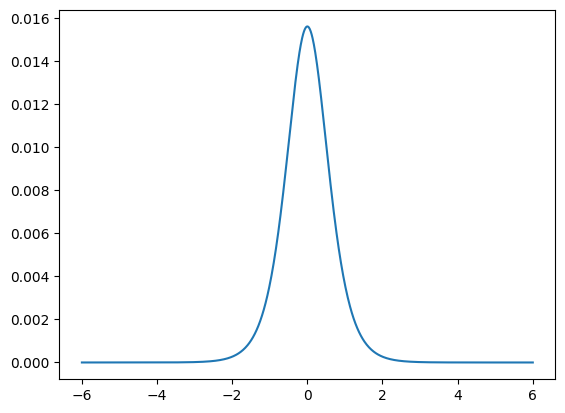

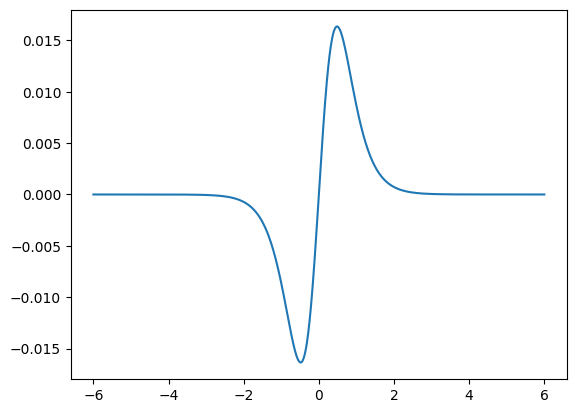

In [2]:
Eh = constants.physical_constants['atomic unit of energy'][0]
V0 = 0.425 * constants.eV / Eh
kB = constants.Boltzmann / Eh
m = 1060
a = 1.36

@njit(nopython=True, fastmath=True)
def V_Eckart(q):
    return V0 / np.cosh(a * q)**2

@njit(nopython=True, fastmath=True)
def F_Eckart(q):
    return 2 * V0 * a * np.sinh(a * q) / (np.cosh(a * q)**3)

q_range = np.linspace(-6,6,1000)
plt.plot(q_range, V_Eckart(q_range))
plt.show()
plt.plot(q_range, F_Eckart(q_range))



## Landscape by diagonalisation in discrete basis

The delta-delta correlation function at $t=0$,
$$C_{dd}(0;x_1,x_2)=\operatorname{tr}[^{-\beta\hat{H}}\delta(q_0-x_1)e^{-\beta\hat{H}}\delta(q_P-x_2)]$$
is the partition function with the $0$-th and $P$-th beads constrained at $x_1$ and $x_2$ respectively. We have
$$C_{dd}(0;x_1,x_2)=|\rho(x_1,x_2)|^2\,,$$
where
$$\rho(x_1,x_2)=\langle x_2 | e^{-\beta\hat{H}/2} | x_1\rangle$$
is $e^{-\beta\hat{H}/2}$ in the position basis. We construct the landscape of $\rho$ by direct diagonalisation of the Hamiltonian in a discrete basis.

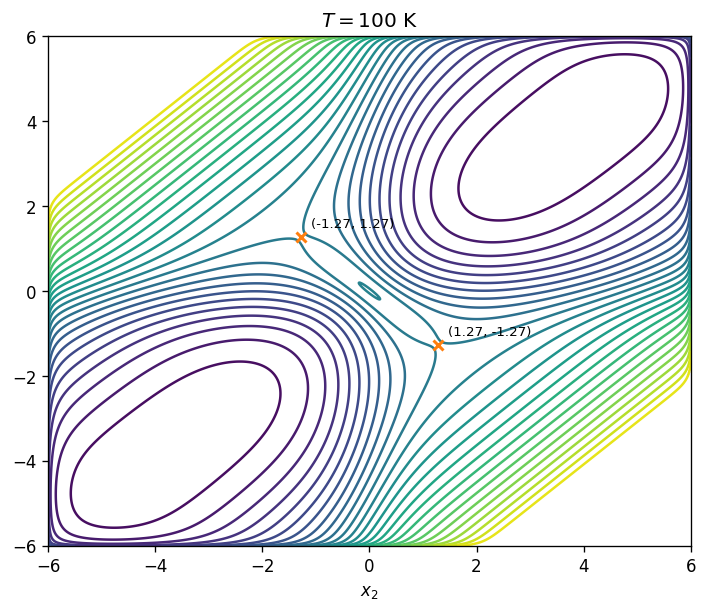

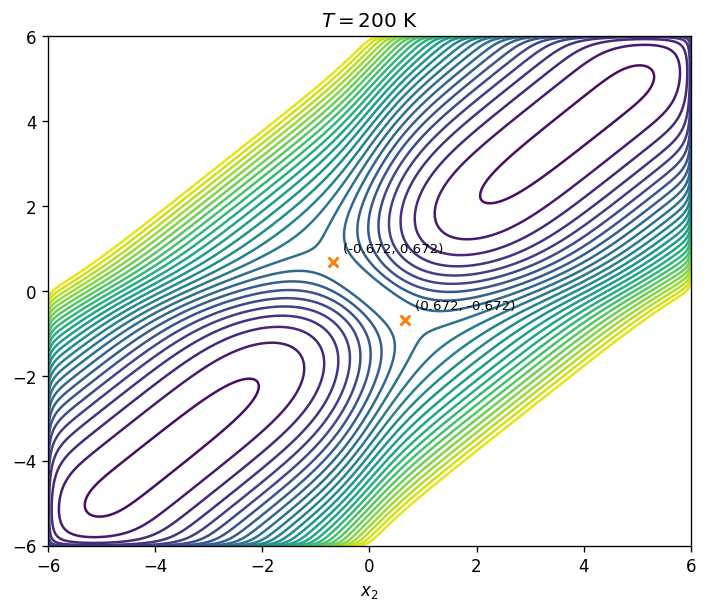

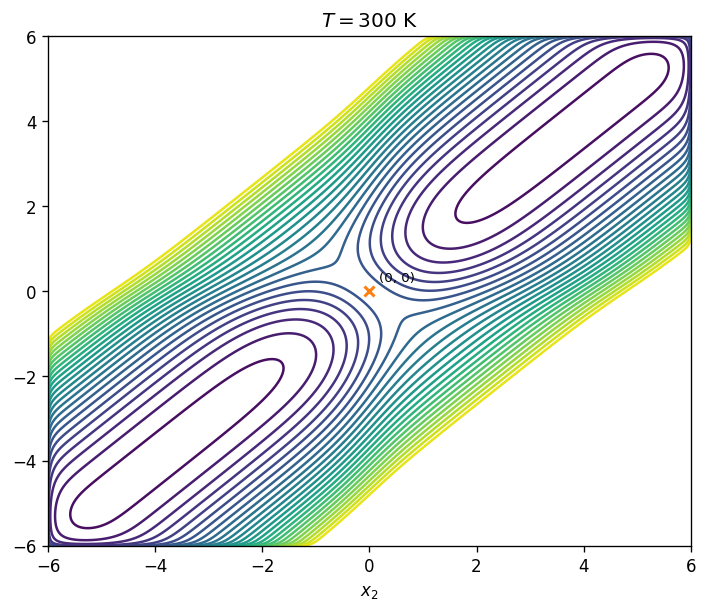

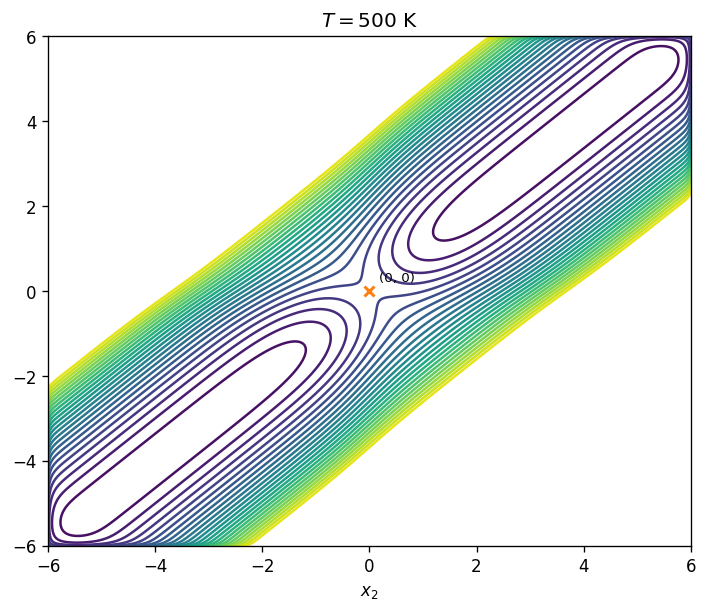

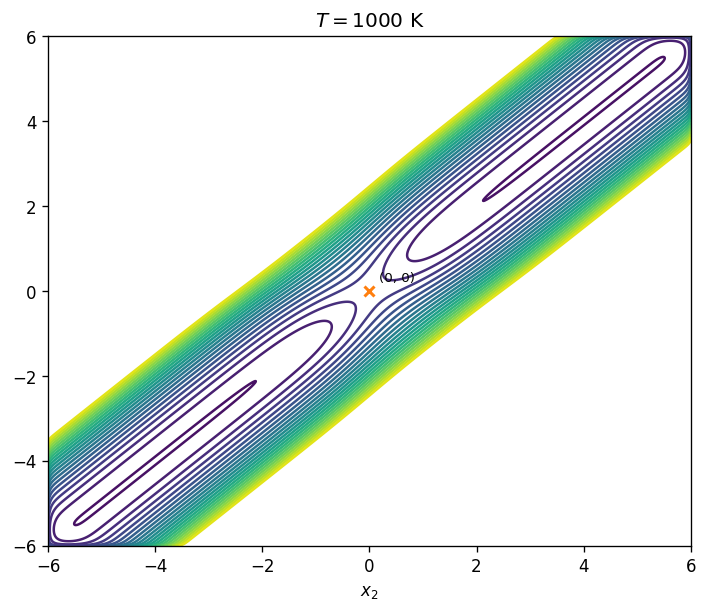

In [3]:
x_min = -6.0
x_max = 6.0
N_grid = 1001
x_grid = np.linspace(x_min,x_max,N_grid)
dx = x_grid[1] - x_grid[0]

V_mat = np.diag(V_Eckart(x_grid))
T_diag = np.ones(N_grid)/(m*dx**2)
T_off_diag = -np.ones(N_grid-1)/(2*m*dx**2)
T_mat = np.diag(T_diag) + np.diag(T_off_diag, 1) + np.diag(T_off_diag, -1)
H_mat = T_mat + V_mat

E, psi = eigh(H_mat)

T_range = [100,200,300,500,1000]

for T in T_range:
    beta = 1 / (kB * T)
    exp_half = np.exp(- 0.5 * beta * E)
    exp_mel = ((exp_half * psi) @ psi.T) / dx

    plot_data = -np.log(np.maximum(exp_mel, 10**(-12 + T/400)))

    diag_list = np.zeros(N_grid)
    for i in range(0,N_grid):
        diag_list[i] = plot_data[i,N_grid-i-1]
    i_min = np.argmin(diag_list)
    
    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    cf = ax.contour(x_grid, x_grid, plot_data, levels=25)
    x0 = x_grid[i_min]
    y0 = x_grid[N_grid - i_min - 1]
    ax.plot([x0], [y0], marker='x', color='C1', markersize=6, fillstyle='none', markeredgewidth=1.8, zorder=5)
    ax.annotate(fr"({x0:.3g}, {y0:.3g})", xy=(x0, y0), xytext=(6, 6),
                textcoords="offset points", fontsize=8)
    if np.abs(x0) > 1e-10:
        ax.plot([y0], [x0], marker='x', color='C1', markersize=6, fillstyle='none', markeredgewidth=1.8, zorder=5)
        ax.annotate(fr"({y0:.3g}, {x0:.3g})", xy=(y0, x0), xytext=(6, 6),
                    textcoords="offset points", fontsize=8)
    ax.set_title(fr"$T={T}\ \mathrm{{K}}$")
    plt.tight_layout()
    plt.xlabel(r'$x_1$')
    plt.xlabel(r'$x_2$')
    plt.show()
    


## Quantum Instanton Rate

The quantum instanton rate is given by
$$k_{\text{QI}}=\frac{\hbar\sqrt{\pi}}{2}\frac{C_{dd}(0)}{Q_r}\frac{C_{ff}(0)}{C_{dd}(0)}\frac{1}{\Delta H}\,.$$
The simplest QI rate is
$$k_{\text{SQI}}=\frac{\hbar\sqrt{\pi}}{2}\frac{C_{dd}(0)}{Q_r}\,,$$
which neglects the last two terms.

## 1. $\frac{C_{dd}(0; x_1^\ddagger, x_2^\ddagger)}{Q_r}$

We would like to work out $\frac{C_{dd}(0; x_1^\ddagger, x_2^\ddagger)}{Q_r}$, where $x_1^\ddagger$ and $x_2^\ddagger$ are the coordinates of two dividing surfaces. However, we can only work out $\frac{C_{dd}(0; x_0, x_0')}{Q_r}$ where $x_0$ and $x_0'$ are two coordinates far from the potential barrier so our particle is essentially free. Therefore, we would like to use thermodynamic integration to work out $\frac{C_{dd}(0; x_1^\ddagger, x_2^\ddagger)}{C_{dd}(0; x_0, x_0')}$.

One could integrate by $x_1$, then $x_2$, one can imagine this as stretching a half of the polymer from far away to the potential barrier, then stretching the other half to the barrier. The thermodynamic integration would then involve plus a huge number then minus a huge number, so the accuracy would be poor. Therefore, we change our coordinates to
\begin{align*}
    \bar{x}=\frac{x_2+x_1}{2}\\
    \delta x=\frac{x_2-x_1}{2}
\end{align*}
so that $x_1=\bar{x}-\delta{x}$ and $x_2=\bar{x}+\delta{x}$. By chain rule,
\begin{align*}
    \frac{\partial}{\partial \bar{x}}&=\frac{\partial}{\partial x_1} + \frac{\partial}{\partial x_2}\,, \\
    \frac{\partial}{\partial \delta x}&=-\frac{\partial}{\partial x_1} + \frac{\partial}{\partial x_2}\,.
\end{align*}

Defining 'free energy'
$$A(\bar{x}, \delta x)=-\frac{1}{\beta}\ln C_{dd}\,,$$
we have derivatives
\begin{align*}
    \frac{\partial A}{\partial \bar{x}}&=-\frac{1}{\beta C_{dd}}\frac{\partial C_{dd}}{\partial \bar{x}}=-\frac{1}{\beta C_{dd}}\left[\frac{\partial C_{dd}}{\partial x_1} + \frac{\partial C_{dd}}{\partial x_2}\right]\,, \\
    \frac{\partial A}{\partial \delta x}&=-\frac{1}{\beta C_{dd}}\frac{\partial C_{dd}}{\partial \delta x}=-\frac{1}{\beta C_{dd}}\left[-\frac{\partial C_{dd}}{\partial x_1} + \frac{\partial C_{dd}}{\partial x_2}\right]\,,
\end{align*}
Then we have
$$\frac{C_{dd}(0; \bar{x}^\ddagger, \delta x^\ddagger)}{C_{dd}(0; \bar{x}_0, \delta x_0)}=\exp(-\beta\Delta A)\,,$$
where
$$\Delta A=-\frac{1}{\beta C_{dd}}\left[ \int_{\bar{x}_0}^{\bar{x}^\ddagger} d\bar{x}\ \left(\frac{\partial C_{dd}}{\partial x_1} + \frac{\partial C_{dd}}{\partial x_2}\right) + \int_{\delta x_0}^{\delta x^\ddagger} d\delta x\ \left(-\frac{\partial C_{dd}}{\partial x_1} + \frac{\partial C_{dd}}{\partial x_2}\right)\right]$$


In [4]:
# Gives the normal mode frequencies of the ring polymer
@njit(nopython=True, fastmath=True)
def normal_mode_frequencies(beta_n, n):
    omega_n = 1.0/beta_n
    k = np.arange(n)
    return 2.0 * omega_n * np.sin(np.pi * k / n)  # omega[0]=0

# Transform the coodinates and velocities into the normal mode coordinates and propagate the dynamics exactly
@njit(nopython=True, fastmath=True)
def mode_propagation(q, v, omega, delta_t):
    #Transform to normal coordinates
    Qk = np.fft.fft(q)
    Vk = np.fft.fft(v)

    Qk_next = np.empty_like(Qk)
    Vk_next = np.empty_like(Vk)

    #Evolve the omega=0 mode
    Qk_next[0] = Qk[0] + Vk[0] * delta_t
    Vk_next[0] = Vk[0]

    # Evolve the omgea>0 mode
    omega_pos = omega[1:]
    coswt = np.cos(omega_pos*delta_t)
    sinwt = np.sin(omega_pos*delta_t)
    Qk_pos = Qk[1:]
    Vk_pos = Vk[1:]
    Qk_next[1:] = Qk_pos * coswt + Vk_pos * (sinwt / omega_pos)
    Vk_next[1:] = Vk_pos * coswt - Qk_pos * (omega_pos * sinwt)
    
    # Transform back to real coordinates
    q_next = np.fft.ifft(Qk_next, axis=0).real
    v_next = np.fft.ifft(Vk_next, axis=0).real
    return q_next, v_next

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [5]:
# Velocity verlet algorithm with RATTLE to constrain the positions of the 0th and Pth beads
@njit(nopython=True, fastmath=True)
def polymer_verlet_rattle(q_init, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P):

    omega = normal_mode_frequencies(beta_n, n)

    q_verlet = np.zeros((N_time, n))
    v_verlet = np.zeros((N_time, n))

    q_init[0] = q0
    q_init[P] = qP
    v_init[0] = 0.0
    v_init[P] = 0.0

    q_verlet[0] = q_init
    v_verlet[0] = v_init

    f = force(q_init)
    for i in range(N_time - 1):
        v_half = v_verlet[i] + 0.5 * delta_t * f / m                                # Propagate velocity half step by external potential
        q_mode, v_mode = mode_propagation(q_verlet[i], v_half, omega, delta_t)      # Propagate velocity and coordinate by mode vibration
        q_mode[0] = q0
        q_mode[P] = qP
        f_new = force(q_mode)
        v_new = v_mode + 0.5 * delta_t * f_new / m                                  # Propagate velocity half step by external potential
        v_new[0] = 0.0
        v_new[P] = 0.0
        f = f_new
        q_verlet[i + 1] = q_mode
        v_verlet[i + 1] = v_new

    return q_verlet, v_verlet


### Thermodynamic Estimator

This estimates the derivatives of $C_{dd}$ naively by directly taking derivatives:
\begin{align*}
    \frac{1}{C_{dd}}\frac{\partial C_{dd}}{\partial x_1}&=\frac{\int d^{n}{\mathbf{p}}\ d^{n}{\mathbf{q}} e^{-\beta_n H(\mathbf{p}, \mathbf{q})} \frac{\partial}{\partial x_1} \delta(q_0-x_1) \delta(q_P - x_2)}{C_{dd}} \\
    &=-\frac{\int d^{n}{\mathbf{p}}\ d^{n}{\mathbf{q}} e^{-\beta_n H(\mathbf{p}, \mathbf{q})} \frac{\partial}{\partial q_0} \delta(q_0-x_1) \delta(q_P - x_2)}{C_{dd}}\\
    &=\frac{\int d^{n}{\mathbf{p}}\ d^{n}{\mathbf{q}} \left(\frac{\partial}{\partial q_0}e^{-\beta_n H(\mathbf{p}, \mathbf{q})}\right) \delta(q_0-x_1) \delta(q_P - x_2)}{C_{dd}}\\
    &=\left\langle -\beta_n \frac{\partial H_n}{\partial q_0}\right\rangle\\
    &=\left\langle -\beta_n \frac{\partial U}{\partial q_0}\right\rangle\\
    &=-\beta_n\left\langle k_{\text{eff}}(2q_0 - q_{n-1} - q_{1}) + \frac{\partial V}{\partial q_0}\right\rangle\,,
\end{align*}
where
$$\langle\cdots\rangle \equiv \frac{\partial C_{dd}}{\partial x_1}=\frac{\int d^{n}{\mathbf{p}}\ d^{n}{\mathbf{q}} e^{-\beta_n H(\mathbf{p}, \mathbf{q})} \cdots \delta(q_0-x_1) \delta(q_P - x_2)}{\int d^{n}{\mathbf{p}}\ d^{n}{\mathbf{q}} e^{-\beta_n H(\mathbf{p}, \mathbf{q})} \delta(q_0-x_1) \delta(q_P - x_2)}$$
is the thermal average in the constrained ensemble.


In [6]:
@njit(nopython=True, fastmath=True)
def Polymer_force_TD(beta, P, N_samp, m, x_bar, delta_x, t_end=100, delta_t = 2, N_pre=10000, force = F_Eckart):
    '''
        This uses the thermodynamic estimator of C_{dd}(0; x_bar, delta x).

        beta: thermodynamic inverse temperature

        P: half the number of beads in the polymer

        N_samp: number of samples

        x_bar: (x_2 + x_1) / 2

        delta_x: (x_2 - x_1) / 2

        t_end: time of polymer evolution

        delta_t: time step

        N_pre: number of steps in pre-equilibration

        force: force function

    '''
    n = 2 * P
    N_time = int(t_end/delta_t)
    beta_n = beta/n

    k_eff = m/beta_n**2

    q0 = x_bar - delta_x
    qP = x_bar + delta_x

    F0 = force(q0)
    FP = force(qP)

    q = x_bar - np.cos(2*np.pi *np.arange(n)/n) * delta_x

    for i in range(N_pre):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = polymer_verlet_rattle(q, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P)
        q = q_verlet[-1]
    
    all_forces_0 = np.zeros(N_samp)
    all_forces_P = np.zeros(N_samp)
    
    for samp in range(N_samp):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = polymer_verlet_rattle(q, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P)
        q = q_verlet[-1]
        all_forces_0[samp] = -F0 + k_eff*(2*q0-q[-1]-q[1])
        all_forces_P[samp] = -FP + k_eff*(2*qP-q[P-1]-q[P+1])

    mean_force_0 = np.mean(all_forces_0)
    stdev_force_0 = np.std(all_forces_0) / np.sqrt(N_samp)
    mean_force_P = np.mean(all_forces_P)
    stdev_force_P = np.std(all_forces_P) / np.sqrt(N_samp)

    mean_force_bar = (mean_force_0 + mean_force_P) / n
    mean_force_delta = (-mean_force_0 + mean_force_P) / n
    stdev_force = np.sqrt(stdev_force_0**2 + stdev_force_P**2) / n
    return mean_force_bar, mean_force_delta, stdev_force

### Virial Estimator

The thermodynamic estimator is straight forward, but it is horrible in convergence because we only sample the forces on 2 beads among $n$, which leads to a very larger variance.

A numerically stable way to take $\partial/\partial x_i$ is to reparameterize the polymer by a tiny displacement $\epsilon$ that:
 - moves the relevant endpoints by $\epsilon$
 - and redistributes that motion over all beads by small shifts $s_k\epsilon$ for $x_1$ (or $t_k \epsilon$ for $x_2$).
Formally, this is a coordinate map
$$q_k\to q_k + s_k \epsilon\,.$$
To ensure the endpoint constraints change correctly, we must set $s_0=1$, $s_P=0$ and $t_0=0$, $t_P=1$. Then by chain rule,
\begin{align*}
    F_{x_1}^V = \left\langle \sum_{k} s_k\partial_{q_k} U\right\rangle\\
    F_{x_2}^V = \left\langle \sum_{k} t_k\partial_{q_k} U\right\rangle\\
\end{align*}

We would like to choose $s_k$ (and $t_k$) to minimise the variance. We split the action into spring and potential contributions. Most of the estimator variance at large $P$ comes from the springs, because they’re stiff. So choose $s_k$ to minimize the spring contribution. Under the coordinate map $q_k\to q_k + s_k \epsilon$, the spring part changes by
$$U_{\text{spr}}(\epsilon)\approx U_{\text{spr}}(0)+\epsilon k_{\text{eff}}\sum_{k}(s_k-s_{k+1})(q_k-q_{k+1})+\frac{1}{2}\epsilon^2k_{\text{eff}}\sum_{k}(s_k-s_{k+1})^2\,.$$
Thus, the minimum-variance weights solve the constrained optimization
$$\min_{\{s_k\}}\sum_{s_k}(s_{k+1}-s_k)^2$$
subject to the constraints $s_0=1$, $s_P=0$ (and periodic boundary condition $s_{k+n}=s_k$). The Euler–Lagrange condition of this discrete quadratic functional is the discrete Laplace equation
$$s_{k+1}-2s_k+s_{k-1}=0\,,$$
which solves to be
$$s_k=\begin{cases}
    1-\frac{k}{P} & 0\le k\le P \\
    \frac{k}{P} - 1 & P\le k \le n\,.
\end{cases}$$
This gives the virial force estimator
$$F_{x_1}=\left\langle \sum_k s_k\left[k_{\text{eff}}(2q_k - q_{k-1} - q_{k+1}) + V'(q_k)\right]\right\rangle\,.$$

The similar virial coefficients for $x_2$ are
$$t_k=\begin{cases}
    \frac{k}{P} & 0\le k\le P \\
    2-\frac{k}{P} & P\le k \le n\,.
\end{cases}$$

In [7]:
@njit(nopython=True, fastmath=True)
def Polymer_force_VI(beta, P, N_samp, m, x_bar, delta_x, t_end=50, delta_t = 5, N_pre=5000, force = F_Eckart):
    '''
        This uses the Virial estimator of C_{dd}(0; x_bar, delta x).

        beta: thermodynamic inverse temperature

        P: half the number of beads in the polymer

        N_samp: number of samples

        x_bar: (x_2 + x_1) / 2

        delta_x: (x_2 - x_1) / 2

        t_end: time of polymer evolution

        delta_t: time step

        N_pre: number of steps in pre-equilibration

        force: force function

    '''
    n = 2 * P
    N_time = int(t_end/delta_t)
    beta_n = beta/n

    k_eff = m/beta_n**2

    # Virial weights
    k = np.arange(n)
    s = np.zeros(n)
    s[:P+1] = 1.0 - (k[:P+1] / P)
    s[P:]   = (k[P:] - P) / P
    t = 1.0 - s
    s[0], s[P] = 1.0, 0.0
    t[0], t[P] = 0.0, 1.0

    # returns array of ∂U/∂q_k for all beads
    def dU_dq_all(q):
        springs = k_eff * (2*q - np.roll(q,1) - np.roll(q,-1))
        pot     = - force(q)
        return springs + pot

    q0 = x_bar - delta_x
    qP = x_bar + delta_x

    q = x_bar - np.cos(2*np.pi *np.arange(n)/n) * delta_x

    for i in range(N_pre):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = polymer_verlet_rattle(q, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P)
        q = q_verlet[-1]
    
    all_forces_0 = np.zeros(N_samp)
    all_forces_P = np.zeros(N_samp)
    
    for samp in range(N_samp):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = polymer_verlet_rattle(q, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P)
        q = q_verlet[-1]
        dU_dq = dU_dq_all(q)
        all_forces_0[samp] = np.dot(s, dU_dq)
        all_forces_P[samp] = np.dot(t, dU_dq)

    mean_force_0 = np.mean(all_forces_0)
    stdev_force_0 = np.std(all_forces_0) / np.sqrt(N_samp)
    mean_force_P = np.mean(all_forces_P)
    stdev_force_P = np.std(all_forces_P) / np.sqrt(N_samp)


    mean_force_bar = (mean_force_0 + mean_force_P) / n
    mean_force_delta = (-mean_force_0 + mean_force_P) / n
    stdev_force = np.sqrt(stdev_force_0**2 + stdev_force_P**2) / n
    return mean_force_bar, mean_force_delta, stdev_force

### Convergence Test

In [8]:
T = 1000
beta = 1/(kB * T)
P = 16
x_bar = -0.3
delta_x = 0

delta_t_range = [1,2,5,10]
t_end_range = [10,20,50,100]

#### Thermodynamic Estimator

In [9]:
TD_bar_mean = []
TD_bar_std = []
TD_del_mean = []
TD_del_std = []

for t_end in tqdm(t_end_range):
    plot_bar_mean = []
    plot_bar_std = []
    plot_del_mean = []
    plot_del_std = []
    for delta_t in delta_t_range:
        data_bar = np.zeros(5)
        data_delta = np.zeros(5)
        for trial in range(5):
            dA_dqbar, dA_ddelq, _ = Polymer_force_TD(beta, P, 50000, m, x_bar, delta_x, t_end=t_end, delta_t=delta_t)
            data_bar[trial] = dA_dqbar
            data_delta[trial] = dA_ddelq
        plot_bar_mean.append(np.mean(data_bar))
        plot_bar_std.append(np.std(data_bar))
        plot_del_mean.append(np.mean(data_delta))
        plot_del_std.append(np.std(data_delta))
    TD_bar_mean.append(plot_bar_mean)
    TD_bar_std.append(plot_bar_std)
    TD_del_mean.append(plot_del_mean)
    TD_del_std.append(plot_del_std)

np.save(f'data/TD_bar.npy', [TD_bar_mean, TD_bar_std])
np.save(f'data/TD_del.npy', [TD_del_mean, TD_del_std])

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [06:47<00:00, 101.87s/it]


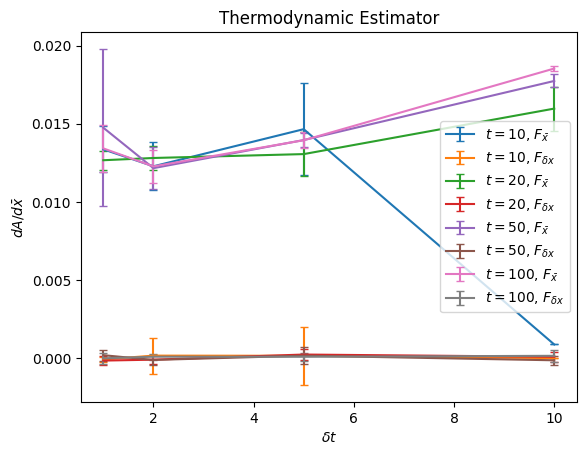

In [10]:
[TD_bar_mean, TD_bar_std] = np.load(f'data/TD_bar.npy')
[TD_del_mean, TD_del_std] = np.load(f'data/TD_del.npy')

for i, t_end in enumerate(t_end_range):
    plt.errorbar(delta_t_range, TD_bar_mean[i], yerr=TD_bar_std[i],capsize=3,label=fr'$t = {t_end}$, $F_{{\bar{{x}}}}$')
    plt.errorbar(delta_t_range, TD_del_mean[i], yerr=TD_del_std[i],capsize=3,label=fr'$t = {t_end}$, $F_{{\delta x}}$')
plt.title('Thermodynamic Estimator')
plt.xlabel(r'$\delta t$')
plt.ylabel(r'$dA/d\bar{x}$')
plt.legend()
plt.legend()
plt.show()

#### Virial Estimator

In [11]:
VI_bar_mean = []
VI_bar_std = []
VI_del_mean = []
VI_del_std = []

for t_end in tqdm(t_end_range):
    plot_bar_mean = []
    plot_bar_std = []
    plot_del_mean = []
    plot_del_std = []
    for delta_t in delta_t_range:
        data_bar = np.zeros(5)
        data_delta = np.zeros(5)
        for trial in range(5):
            dA_dqbar, dA_ddelq, _ = Polymer_force_VI(beta, P, 50000, m, x_bar, delta_x, t_end=t_end, delta_t=delta_t)
            data_bar[trial] = dA_dqbar
            data_delta[trial] = dA_ddelq
        plot_bar_mean.append(np.mean(data_bar))
        plot_bar_std.append(np.std(data_bar))
        plot_del_mean.append(np.mean(data_delta))
        plot_del_std.append(np.std(data_delta))
    VI_bar_mean.append(plot_bar_mean)
    VI_bar_std.append(plot_bar_std)
    VI_del_mean.append(plot_del_mean)
    VI_del_std.append(plot_del_std)
    
np.save(f'data/VI_bar.npy', [VI_bar_mean, VI_bar_std])
np.save(f'data/VI_del.npy', [VI_del_mean, VI_del_std])


100%|██████████| 4/4 [05:35<00:00, 83.82s/it] 


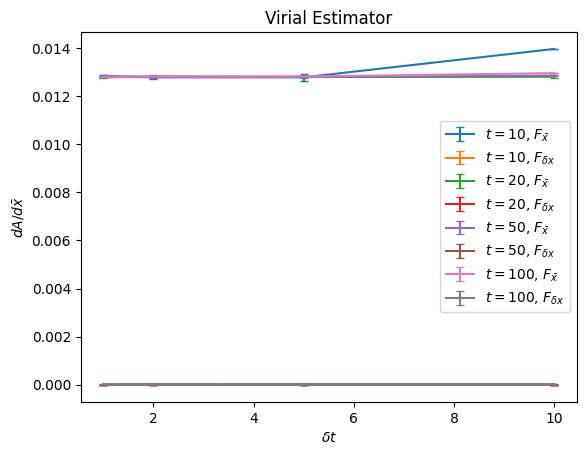

In [12]:
[VI_bar_mean, VI_bar_std] = np.load(f'data/VI_bar.npy')
[VI_del_mean, VI_del_std] = np.load(f'data/VI_del.npy')

for i, t_end in enumerate(t_end_range):
    plt.errorbar(delta_t_range, VI_bar_mean[i], yerr=VI_bar_std[i],capsize=3,label=fr'$t = {t_end}$, $F_{{\bar{{x}}}}$')
    plt.errorbar(delta_t_range, VI_del_mean[i], yerr=VI_del_std[i],capsize=3,label=fr'$t = {t_end}$, $F_{{\delta x}}$')
plt.title('Virial Estimator')
plt.xlabel(r'$\delta t$')
plt.ylabel(r'$dA/d\bar{x}$')
plt.legend()
plt.show()

We see that the virial estimator has MUCH better convergence.

### Full Landscape (Unnecessary)

In [13]:
def A_profile(x_bar_range, delta_x_range, dA_dxbar_array, dA_ddelx_array):
    x = np.asarray(x_bar_range)
    d = np.asarray(delta_x_range)
    Fx = np.asarray(dA_dxbar_array)
    Fy = np.asarray(dA_ddelx_array)

    nx, nd = Fx.shape
    assert Fy.shape == (nx, nd)

    # Integrate Fx along x_bar for each fixed del_x (axis 0)
    A_x = np.zeros_like(Fx, dtype=float)
    for j in range(nd):
        A_x[:, j] = integrate.cumulative_trapezoid(Fx[:, j], x, initial=0.0)

    # Integrate Fy along del_x for each fixed x_bar (axis 1)
    A_d = np.zeros_like(Fx, dtype=float)
    for i in range(nx):
        A_d[i, :] = integrate.cumulative_trapezoid(Fy[i, :], d, initial=0.0)

    # Path 1
    A = A_d + A_x[:, 0][:, None]

    return A



### 1000 K

In [14]:
x_bar_range = np.concatenate((
    np.arange(-6,-2,0.5),
    np.arange(-2,0.5,0.1)
))

delta_x_range = np.arange(0,1.6,0.2)

dA_dxbar_array = np.zeros((len(x_bar_range), len(delta_x_range)))
dA_ddelx_array = np.zeros((len(x_bar_range), len(delta_x_range)))

T = 1000
beta = 1/(kB * T)
P = 16
for i,x_bar in enumerate(tqdm(x_bar_range)):
    for j,delta_x in enumerate(delta_x_range):
        dA_dxbar, dA_ddelx, _ = Polymer_force_VI(beta, P, 50000, m, x_bar, delta_x)
        dA_dxbar_array[i,j] = dA_dxbar
        dA_ddelx_array[i,j] = dA_ddelx
np.save(f'data/dA_dxbar_array_1000.npy', dA_dxbar_array)
np.save(f'data/dA_ddelx_array_1000.npy', dA_ddelx_array)

100%|██████████| 33/33 [10:38<00:00, 19.35s/it]


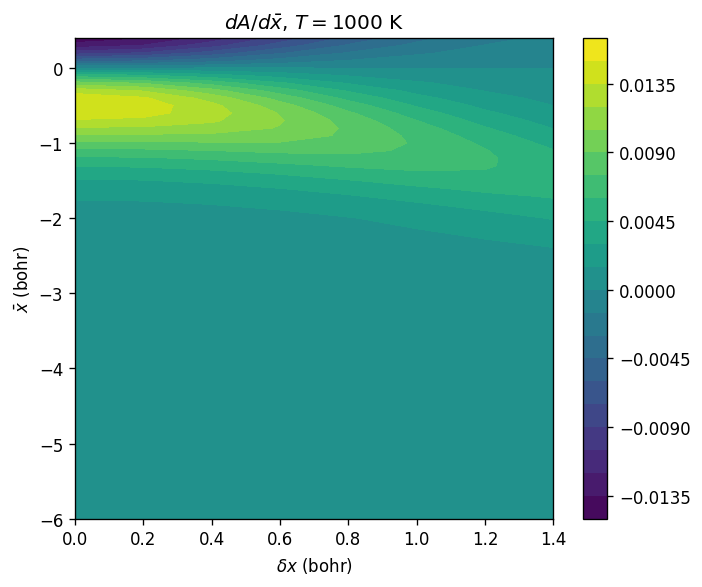

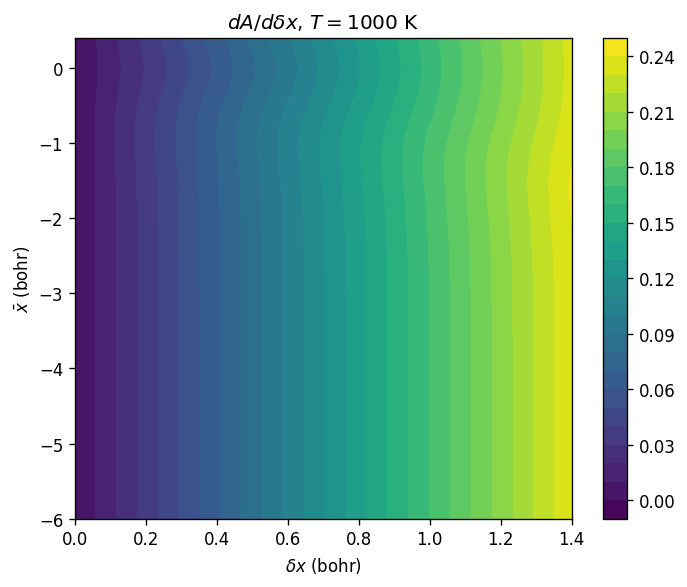

In [15]:
dA_dxbar_array = np.load(f'data/dA_dxbar_array_1000.npy')
dA_ddelx_array = np.load(f'data/dA_ddelx_array_1000.npy')

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
cf = ax.contourf(delta_x_range, x_bar_range, dA_dxbar_array, levels=25)
cbar = fig.colorbar(cf, ax=ax)
ax.set_xlabel(r"$\delta x\ \mathrm{(bohr)}$")
ax.set_ylabel(r"$\bar{x}\ \mathrm{(bohr)}$")
ax.set_title(fr"$dA/d\bar{{x}}$, $T={T}\ \mathrm{{K}}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
cf = ax.contourf(delta_x_range, x_bar_range, dA_ddelx_array, levels=25)
cbar = fig.colorbar(cf, ax=ax)
ax.set_xlabel(r"$\delta x\ \mathrm{(bohr)}$")
ax.set_ylabel(r"$\bar{x}\ \mathrm{(bohr)}$")
ax.set_title(fr"$dA/d\delta x$, $T={T}\ \mathrm{{K}}$")
plt.tight_layout()
plt.show()

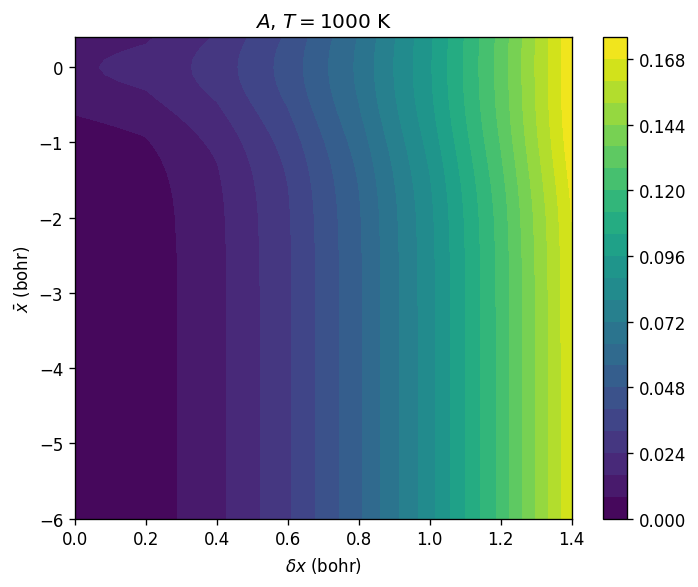

In [16]:
A_plot = A_profile(x_bar_range, delta_x_range, dA_dxbar_array, dA_ddelx_array)
fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
cf = ax.contourf(delta_x_range, x_bar_range, A_plot, levels=25)
cbar = fig.colorbar(cf, ax=ax)
ax.set_xlabel(r"$\delta x\ \mathrm{(bohr)}$")
ax.set_ylabel(r"$\bar{x}\ \mathrm{(bohr)}$")
ax.set_title(fr"$A$, $T={T}\ \mathrm{{K}}$")
plt.tight_layout()
plt.show()

### 200 K

In [17]:
x_bar_range = np.concatenate((
    np.arange(-6,-2,0.5),
    np.arange(-2,0.5,0.1)
))

delta_x_range = np.arange(0,1.6,0.2)

dA_dxbar_array = np.zeros((len(x_bar_range), len(delta_x_range)))
dA_ddelx_array = np.zeros((len(x_bar_range), len(delta_x_range)))

T = 200
beta = 1/(kB * T)
P = 80
for i,x_bar in enumerate(tqdm(x_bar_range)):
    for j,delta_x in enumerate(delta_x_range):
        dA_dxbar, dA_ddelx, _ = Polymer_force_VI(beta, P, 50000, m, x_bar, delta_x)
        dA_dxbar_array[i,j] = dA_dxbar
        dA_ddelx_array[i,j] = dA_ddelx
np.save(f'data/dA_dxbar_array_200.npy', dA_dxbar_array)
np.save(f'data/dA_ddelx_array_200.npy', dA_ddelx_array)

100%|██████████| 33/33 [26:48<00:00, 48.75s/it]


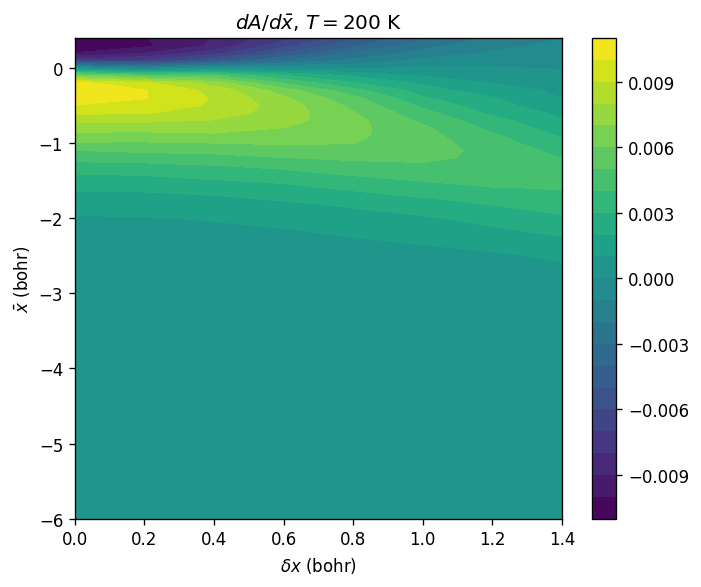

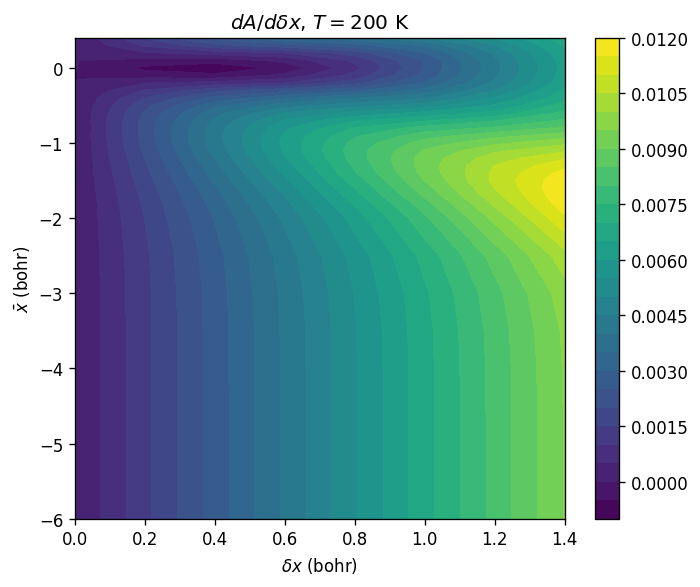

In [18]:
dA_dxbar_array = np.load(f'data/dA_dxbar_array_200.npy')
dA_ddelx_array = np.load(f'data/dA_ddelx_array_200.npy')

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
cf = ax.contourf(delta_x_range, x_bar_range, dA_dxbar_array, levels=25)
cbar = fig.colorbar(cf, ax=ax)
ax.set_xlabel(r"$\delta x\ \mathrm{(bohr)}$")
ax.set_ylabel(r"$\bar{x}\ \mathrm{(bohr)}$")
ax.set_title(fr"$dA/d\bar{{x}}$, $T={T}\ \mathrm{{K}}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
cf = ax.contourf(delta_x_range, x_bar_range, dA_ddelx_array, levels=25)
cbar = fig.colorbar(cf, ax=ax)
ax.set_xlabel(r"$\delta x\ \mathrm{(bohr)}$")
ax.set_ylabel(r"$\bar{x}\ \mathrm{(bohr)}$")
ax.set_title(fr"$dA/d\delta x$, $T={T}\ \mathrm{{K}}$")
plt.tight_layout()
plt.show()

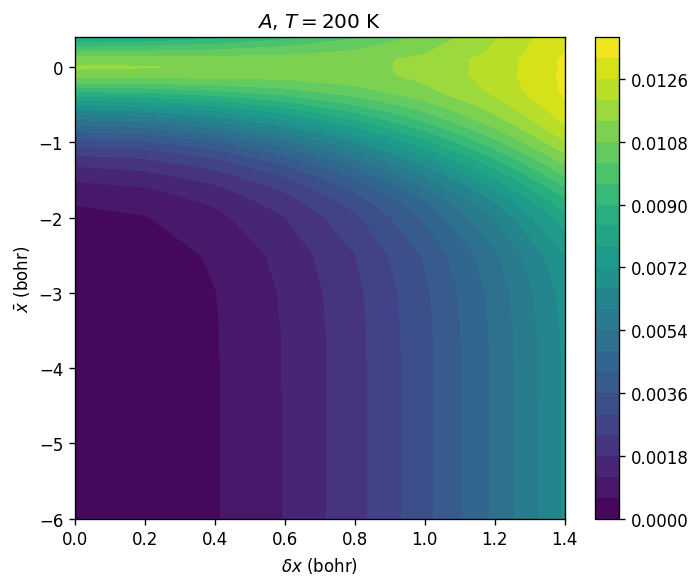

In [19]:
A_plot = A_profile(x_bar_range, delta_x_range, dA_dxbar_array, dA_ddelx_array)
fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
cf = ax.contourf(delta_x_range, x_bar_range, A_plot, levels=25)
cbar = fig.colorbar(cf, ax=ax)
ax.set_xlabel(r"$\delta x\ \mathrm{(bohr)}$")
ax.set_ylabel(r"$\bar{x}\ \mathrm{(bohr)}$")
ax.set_title(fr"$A$, $T={T}\ \mathrm{{K}}$")
plt.tight_layout()
plt.show()

### Along $\bar{x}$ at $\delta x=0$

In [20]:
# Error in trapezoid integration
def cumulative_trapz_se(x, sigma):
    x = np.asarray(x)
    sigma = np.asarray(sigma)
    n = len(x)
    dx = np.diff(x)               # length n-1
    se = np.zeros(n)
    if n == 1:
        return se

    for k in range(1, n):
        a = np.zeros(k+1)
        a[0] = 0.5*dx[0]
        a[-1] = 0.5*dx[k-1]
        if k > 1:
            a[1:-1] = 0.5*dx[:k-1] + 0.5*dx[1:k]
        se[k] = np.sqrt(np.sum((a**2)*(sigma[:k+1]**2)))
    return se

In [21]:
T_calc = [100, 200, 300, 500, 1000, 2000]
T_read = [100, 200, 300, 500, 1000, 2000]

P_map = {
    100: 160,
    200: 80,
    300: 54,
    500: 32,
    1000: 16,
    2000: 8
}

In [22]:
x_bar_range = np.concatenate((
    np.arange(-6,-2.5,0.5),
    np.arange(-2.5,-2,0.1),
    np.arange(-2,0.4,0.05),
))

In [23]:
for T in T_calc:
    beta = 1/(kB * T)
    P = P_map[T]
    dA_dxbar_array = np.zeros_like(x_bar_range)
    dA_dxbar_err_array = np.zeros_like(x_bar_range)
    for i, x_bar in enumerate(tqdm(x_bar_range)):
        dA_dxbar, _, dA_dxbar_err = Polymer_force_VI(beta, P, 100000, m, x_bar, delta_x=0)
        dA_dxbar_array[i] = dA_dxbar
        dA_dxbar_err_array[i] = dA_dxbar_err
    np.save(f'data/dA_dxbar_{T}.npy', [x_bar_range, dA_dxbar_array, dA_dxbar_err_array])

100%|██████████| 60/60 [03:38<00:00,  3.64s/it]


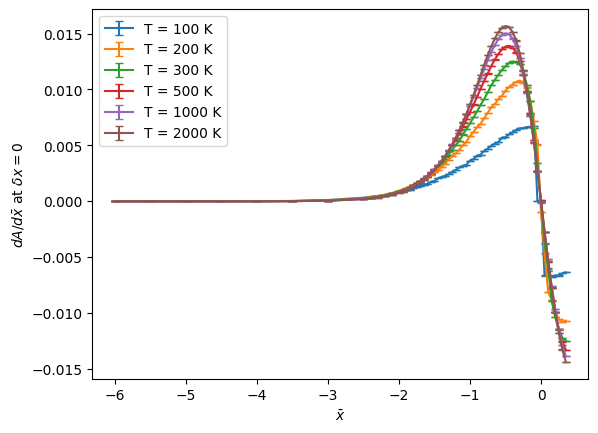

In [24]:
for T in T_read:
    x_bar_range, dA_dxbar, dA_dxbar_err = np.load(f'data/dA_dxbar_{T}.npy')
    plt.errorbar(x_bar_range[:60], dA_dxbar[:60], yerr = dA_dxbar_err[:60], label=f'T = {T} K', capsize=3)
plt.xlabel(r'$\bar{x}$')
plt.ylabel(r'$dA/d\bar{x}$ at $\delta x=0$')
plt.legend()

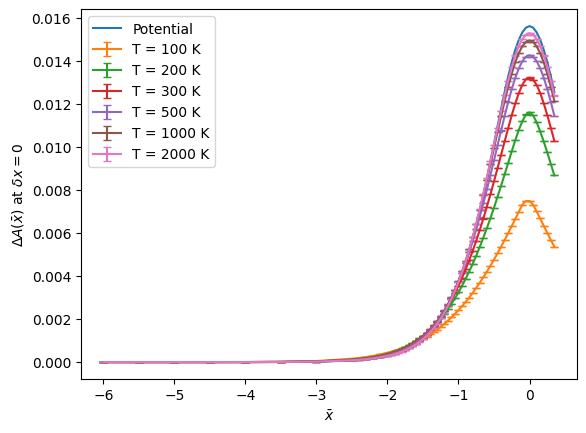

In [25]:
plt.plot(x_bar_range, V_Eckart(x_bar_range), label='Potential')
for T in T_read:
    x_bar_range, dA_dxbar, dA_dxbar_err = np.load(f'data/dA_dxbar_{T}.npy')
    A_landscape = integrate.cumulative_trapezoid(dA_dxbar, x_bar_range, initial=0.0)
    A_landscape_err = cumulative_trapz_se(x_bar_range, dA_dxbar_err)
    plt.errorbar(x_bar_range, A_landscape, yerr=A_landscape_err, label=f'T = {T} K', capsize=3)
    i0 = np.argmin(np.abs(x_bar_range))
    A_qbar_zero = A_landscape[i0]
    A_qbar_zero_err = A_landscape_err[i0]
    np.save(f'data/A_qbar_zero_{T}.npy', [A_qbar_zero, A_qbar_zero_err])

plt.xlabel(r'$\bar{x}$')
plt.ylabel(r'$\Delta A(\bar{x})$ at $\delta x=0$')
plt.legend()



### Along $\delta x$ at $\bar{x}=0$

In [26]:
del_x_range = np.arange(0,1.5,0.04)

In [27]:
for T in T_calc:
    beta = 1/(kB * T)
    P = P_map[T]
    dA_ddelx_array = np.zeros_like(x_bar_range)
    dA_ddelx_err_array = np.zeros_like(x_bar_range)
    for i, del_x in enumerate(tqdm(del_x_range)):
        if T < 200:
            _, dA_ddelx, dA_ddelx_err = Polymer_force_VI(beta, P, 100000, m, 0, del_x, t_end = 30, delta_t=3)
        else:
            _, dA_ddelx, dA_ddelx_err = Polymer_force_VI(beta, P, 100000, m, 0, del_x)
        dA_ddelx_array[i] = dA_ddelx
        dA_ddelx_err_array[i] = dA_ddelx_err
    np.save(f'data/dA_ddelx_{T}.npy', [del_x_range, dA_ddelx_array, dA_ddelx_err_array])

  0%|          | 0/38 [00:25<?, ?it/s]


KeyboardInterrupt: 

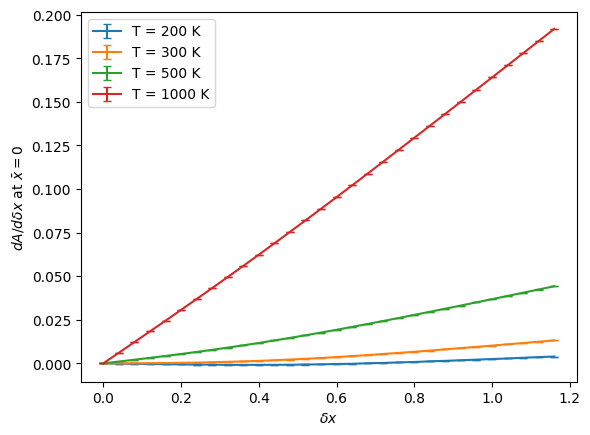

In [ ]:
for T in T_read:
    del_x_range, dA_ddelx_array, dA_ddelx_err_array = np.load(f'data/dA_ddelx_{T}.npy')
    plt.errorbar(del_x_range, dA_ddelx, yerr = dA_ddelx_err, label=f'T = {T} K', capsize=3)
plt.xlabel(r'$\delta x$')
plt.ylabel(r'$dA/d\delta x$ at $\bar{x}=0$')
plt.legend()

-------- T = 200 K --------
delta x = 0.68
delta A = 0.0111 ± 2.6821e-06
C_dd/C_dd ref = 2.3972e-08 ± 1.0151e-10
---------------------------
-------- T = 300 K --------
delta x = 0.00
delta A = 0.0132 ± 1.5944e-06
C_dd/C_dd ref = 9.0788e-07 ± 1.5236e-09
---------------------------
-------- T = 500 K --------
delta x = 0.00
delta A = 0.0143 ± 1.4299e-06
C_dd/C_dd ref = 1.2094e-04 ± 1.0921e-07
---------------------------
-------- T = 1000 K --------
delta x = 0.00
delta A = 0.0150 ± 1.1213e-06
C_dd/C_dd ref = 8.8987e-03 ± 3.1509e-06
---------------------------


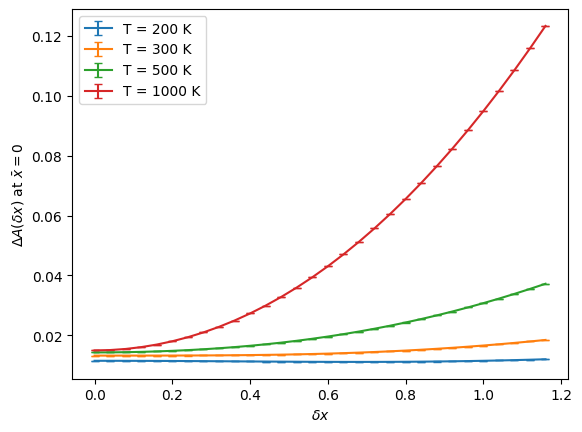

In [ ]:
for T in T_read:
    x_bar_range, dA_dxbar, dA_dxbar_err = np.load(f'data/dA_ddelx_{T}.npy')
    A_landscape = integrate.cumulative_trapezoid(dA_ddelx, del_x_range, initial=0.0)
    A_landscape_err = cumulative_trapz_se(del_x_range, dA_ddelx_err)

    A_qbar_zero, A_qbar_zero_err = np.load(f'data/A_qbar_zero_{T}.npy')
    A_landscape += A_qbar_zero
    A_landscape_err = np.sqrt(A_qbar_zero_err**2 + A_landscape_err**2)
    plt.errorbar(del_x_range, A_landscape, yerr = A_landscape_err, label=f'T = {T} K', capsize=3)

    delta_A = np.min(A_landscape)
    arg_saddle = np.argmin(A_landscape)
    delta_A_err = A_landscape_err[arg_saddle]
    np.save(f'data/delta_A_{T}.npy', [delta_A, delta_A_err])

    saddle_delx = del_x_range[arg_saddle]
    np.save(f'data/saddle_delx_{T}.npy', saddle_delx)

    Cdd_ratio = np.exp(- delta_A/(kB * T))
    Cdd_ratio_err = delta_A_err/(kB * T) * Cdd_ratio
    np.save(f'data/Cdd_ratio_{T}.npy', [Cdd_ratio, Cdd_ratio_err])

    print(f'-------- T = {T} K --------')
    print(f'delta x = {saddle_delx:.2f}')
    print(f'delta A = {delta_A:.4f} ± {delta_A_err:.4e}')
    print(f'C_dd/C_dd ref = {Cdd_ratio:.4e} ± {Cdd_ratio_err:.4e}')
    print(f'---------------------------')
plt.xlabel(r'$\delta x$')
plt.ylabel(r'$\Delta A(\delta x)$ at $\bar{x}=0$')
plt.legend()

### $\frac{C_{dd}(0; \bar{x}_0, \delta x_0)}{Q_r}$

This can be done analytically for free particles. The thermal density matrix with imaginary time $\tau$ in the $x$ basis is
$$\rho_\tau(x_1,x_2)=\langle x_2 | e^{-\beta\tau} | x_1\rangle = \int dp\ \langle x_2 | p\rangle e^{-\tau p^2/2m}\langle p | x\rangle = \left(\frac{m}{2\pi\hbar^2 \tau}\right)^{1/2}\exp\left[-\frac{m(x_2-x_1)^2}{2\hbar^2\tau}\right]\,.$$
The delta-delta correlation function with $x_2-x_1=2\delta x=0$ is therefore
$$C_{dd}(0; \bar{x}_0, \delta x_0=0)=|\rho_{\beta/2}(x_2-x_1=0)|^2=\frac{m}{\pi\hbar^2\beta}\,.$$
The partition function per unit volume is
$$Q_r=\left(\frac{m}{2\pi\hbar^2\beta}\right)^{1/2}\,,$$
so
$$\frac{C_{dd}(0; \bar{x}_0, \delta x_0)}{Q_r}=\sqrt{\frac{2m}{\pi\beta\hbar^2}}\,.$$

In [ ]:
for i, T in T_read:
    beta = 1/(kB * T)
    reference_ratio = np.sqrt(2*m/(np.pi * beta))
    Cdd_ratio, Cdd_ratio_err = np.load(f'data/Cdd_ratio_{T}.npy')

    Cdd_Qr = Cdd_ratio * reference_ratio
    Cdd_Qr_err = Cdd_ratio_err * reference_ratio
    np.save(f'data/Cdd_Qr_{T}', [Cdd_Qr, Cdd_Qr_err])

    k_SQI = np.sqrt(np.pi) * Cdd_Qr/2
    k_SQI_err = np.sqrt(np.pi) * Cdd_Qr_err/2
    np.save(f'data/k_SQI_{T}.npy', [k_SQI, k_SQI_err])

    print(f'-------- T = {T} K --------')
    print(f'C_dd/Q_r = {Cdd_Qr:.4e} ± {Cdd_Qr_err:.4e}')
    print(f'k_SQI = {k_SQI:.4e} ± {k_SQI_err:.4e}')
    print(f'---------------------------')

-------- T = 200 K --------
C_dd/Q_r = 1.5672e-08 ± 6.6366e-11
k_SQI = 1.3889e-08 ± 5.8816e-11
---------------------------
-------- T = 300 K --------
C_dd/Q_r = 7.2693e-07 ± 1.2199e-09
k_SQI = 6.4423e-07 ± 1.0811e-09
---------------------------
-------- T = 500 K --------
C_dd/Q_r = 1.2501e-04 ± 1.1289e-07
k_SQI = 1.1079e-04 ± 1.0005e-07
---------------------------
-------- T = 1000 K --------
C_dd/Q_r = 1.3009e-02 ± 4.6062e-06
k_SQI = 1.1529e-02 ± 4.0822e-06
---------------------------


## 2. $\frac{C_{ff}(0)}{C_{dd}(0)}$ and $\Delta H^2$

By Yamamoto and Miller,
\begin{align*}
    \frac{C_{ff}(0)}{C_{dd}(0)}&=\langle f_v(\mathbf{q})\rangle\\
    \Delta H^2 &= \frac{1}{2}\langle F(\mathbf{q})^2 + G(\mathbf{q}) \rangle \,,
\end{align*}
where the estimators are
\begin{align*}
    f_v&= -m\left(\frac{P}{\hbar\beta}\right)^2(q_1 - q_{n-1})(q_{P+1}-q_{P-1})\,, \\
    F&=-\frac{mn}{\hbar^2\beta^2}\left\{\sum_{k=1}^{P}-\sum_{k=P+1}^{n}\right\}(q_k - q_{k-1})^2 + \frac{2}{n}\left\{\sum_{k=0}^{P-1}-\sum_{k=P}^{n-1}\right\}V(\mathbf{q})\,, \\
    G &= \frac{2n}{\beta^2}-\frac{4mn}{\hbar^2\beta^2}\sum_{k=1}^{P}(x_k - x_{k-1})^2\,.
\end{align*}


In [ ]:
@njit(nopython=True, fastmath=True)
def Polymer_ff_and_H(beta, P, N_samp, m, x_bar, delta_x, t_end=100, delta_t = 2, N_pre=10000, potential = V_Eckart, force = F_Eckart):
    '''
        This uses the estimators f_v, G and H to sample C_ff/C_dd and Delta H^2.

        beta: thermodynamic inverse temperature

        P: half the number of beads in the polymer

        N_samp: number of samples

        x_bar: (x_2 + x_1) / 2

        delta_x: (x_2 - x_1) / 2

        t_end: time of polymer evolution

        delta_t: time step

        N_pre: number of steps in pre-equilibration

        force: force function

    '''
    n = 2 * P
    N_time = int(t_end/delta_t)
    beta_n = beta/n

    q0 = x_bar - delta_x
    qP = x_bar + delta_x

    q = x_bar - np.cos(2*np.pi *np.arange(n)/n) * delta_x

    for i in range(N_pre):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = polymer_verlet_rattle(q, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P)
        q = q_verlet[-1]
    
    all_fv = np.zeros(N_samp)
    all_F = np.zeros(N_samp)
    all_G = np.zeros(N_samp)

    F_first_sign = -np.ones(n)
    F_first_sign[1:P+1] = 1
    F_sec_sign = np.ones(n)
    F_sec_sign[P:] = -1
    F_sec_sign[0] = F_sec_sign[P] = 0

    for samp in range(N_samp):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)
        q_verlet, _ = polymer_verlet_rattle(q, v_init, beta_n, N_time, delta_t, n, force, m, q0, qP, P)
        q = q_verlet[-1]

        all_fv[samp] = (q[1]-q[-1]) * (q[P+1]-q[P-1])

        q_roll = np.roll(q, 1)
        diff_sq = (q - q_roll)**2

        F_first = -m*n*np.sum(F_first_sign * diff_sq)/(beta**2)
        V_q = potential(q)
        F_sec = np.sum(F_sec_sign * V_q) / P

        all_F[samp] = F_first + F_sec

        all_G[samp] = np.sum(diff_sq)

    mean_fv = np.mean(all_fv)
    stdev_fv = np.std(all_fv) / np.sqrt(N_samp)
    mean_fv *= -m*(P/beta)**2
    stdev_fv *= m*(P/beta)**2

    all_del_H_sq = all_F**2 + 2*n/(beta**2) - 4*m*n*all_G/(beta**3)

    mean_del_H_sq = 0.5 * np.mean(all_del_H_sq)
    stdev_del_H_sq = 0.5 * np.std(all_del_H_sq) / np.sqrt(N_samp)

    mean_del_H = np.sqrt(mean_del_H_sq)
    stdev_del_H = 0.5 * stdev_del_H_sq / mean_del_H

    return mean_fv, mean_del_H, stdev_fv, stdev_del_H

C:\Users\wu152\AppData\Roaming\Python\Python312\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [ ]:
for T in tqdm(T_calc):
    beta = 1/(kB * T)
    P = P_map[T]
    x_bar = 0
    saddle_delx = np.load(f'data/saddle_delx_{T}.npy')
    C_ff, Del_H, std_ff, std_H = Polymer_ff_and_H(beta, P, 1000000, m, x_bar, delta_x)

    np.save(f'data/C_ff_{T}.npy', [C_ff, std_ff])
    np.save(f'data/Del_H_{T}.npy', [Del_H, std_H])

100%|██████████| 4/4 [29:21<00:00, 440.25s/it]


In [ ]:
for T in T_read:
    C_ff, std_ff = np.load(f'data/C_ff_{T}.npy')
    Del_H, std_H = np.load(f'data/Del_H_{T}.npy')
    k_SQI, k_SQI_err = np.load(f'data/k_SQI_{T}.npy')
    
    beta = 1/(kB * T)
    Del_H_mod = Del_H + (np.sqrt(np.pi)-np.sqrt(2))/beta
    k_QI = k_SQI * C_ff / Del_H
    k_QI_err = (k_SQI_err/k_SQI + std_ff/C_ff + std_H/Del_H) * k_QI
    k_QI_mod = k_SQI * C_ff / Del_H_mod
    k_QI_mod_err = (k_SQI_err/k_SQI + std_ff/C_ff + std_H/Del_H_mod) * k_QI_mod

    np.save(f'data/k_QI_{T}.npy', [k_QI, k_QI_err])
    np.save(f'data/k_QI_mod_{T}.npy', [k_QI_mod, k_QI_mod_err])

    print(f'-------- T = {T} K --------')
    print(f'C_ff/C_dd = {C_ff:.4e} ± {std_ff:.4e}')
    print(f'Δ H  = {Del_H:.4e} ± {std_H:.4e}')
    print(f'k_SQI  = {k_SQI:.4e} ± {k_SQI_err:.4e}')
    print(f'k_QI  = {k_QI:.4e} ± {k_QI_err:.4e}')
    print(f'k_QI_mod  = {k_QI_mod:.4e} ± {k_QI_mod_err:.4e}')
    print(f'---------------------------')

-------- T = 200 K --------
C_ff/C_dd = 2.8108e-03 ± 8.3057e-05
Δ H  = 2.2594e-03 ± 3.5343e-05
k_SQI  = 1.3889e-08 ± 5.8816e-11
k_QI  = 1.7279e-08 ± 8.5404e-10
k_QI_mod  = 1.5702e-08 ± 7.5368e-10
---------------------------
-------- T = 300 K --------
C_ff/C_dd = 4.6412e-03 ± 6.5509e-05
Δ H  = 3.9556e-03 ± 2.3957e-05
k_SQI  = 6.4423e-07 ± 1.0811e-09
k_QI  = 7.5588e-07 ± 1.6516e-08
k_QI_mod  = 6.9600e-07 ± 1.4873e-08
---------------------------
-------- T = 500 K --------
C_ff/C_dd = 3.0553e-03 ± 5.1984e-05
Δ H  = 3.9184e-03 ± 3.0899e-05
k_SQI  = 1.1079e-04 ± 1.0005e-07
k_QI  = 8.6383e-05 ± 2.2290e-06
k_QI_mod  = 7.5459e-05 ± 1.8718e-06
---------------------------
-------- T = 1000 K --------
C_ff/C_dd = 4.1163e-03 ± 4.9119e-05
Δ H  = 5.3166e-03 ± 4.0442e-05
k_SQI  = 1.1529e-02 ± 4.0822e-06
k_QI  = 8.9258e-03 ± 1.7757e-04
k_QI_mod  = 7.3561e-03 ± 1.3650e-04
---------------------------


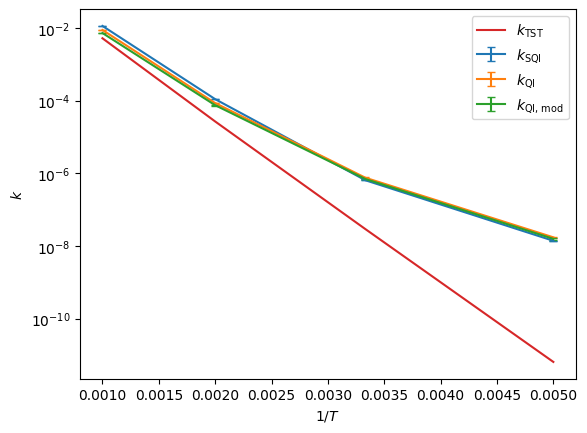

In [ ]:
inv_T, k_SQI_list, k_SQI_err_list, k_QI_list, k_QI_err_list, k_QI_mod_list, k_QI_mod_err_list, k_cl_list = [], [], [], [], [], [], [], []

for T in T_read:
    inv_T.append(1/T)
    k_SQI, k_SQI_err = np.load(f'data/k_SQI_{T}.npy')
    k_QI, k_QI_err = np.load(f'data/k_QI_{T}.npy')
    k_QI_mod, k_QI_mod_err = np.load(f'data/k_QI_mod_{T}.npy')
    k_SQI_list.append(k_SQI)
    k_SQI_err_list.append(k_SQI_err)
    k_QI_list.append(k_QI)
    k_QI_err_list.append(k_QI_err)
    k_QI_mod_list.append(k_QI_mod)
    k_QI_mod_err_list.append(k_QI_mod_err)
    k_cl_list.append(np.sqrt(m * kB * T/(2*np.pi)) * np.exp(-V0/(kB * T)))
    


plt.errorbar(inv_T, k_SQI_list, yerr=k_SQI_err_list, label=r'$k_{\text{SQI}}$', capsize = 3)
plt.errorbar(inv_T, k_QI_list, yerr=k_QI_err_list, label=r'$k_{\text{QI}}$', capsize = 3)
plt.errorbar(inv_T, k_QI_mod_list, yerr=k_QI_mod_err_list, label=r'$k_{\text{QI, mod}}$', capsize = 3)
plt.plot(inv_T, k_cl_list, label=r'$k_{\text{TST}}$')
plt.xlabel(r'$1/T$')
plt.ylabel(r'$k$')
plt.legend()
plt.yscale('log')